In [35]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mode
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Initialize cache for impurity calculation
impurity_cache = {}

In [36]:
# Cached impurity calculation
def cached_impurity(target_col, criterion_func):
    key = hash(target_col.tostring())
    if key in impurity_cache:
        return impurity_cache[key]
    impurity_value = criterion_func(target_col)
    impurity_cache[key] = impurity_value
    return impurity_value

In [37]:
# Define weighted entropy
def weighted_entropy(target_col, weights):
    total = np.sum(weights)
    values, counts = np.unique(target_col, return_counts=True)
    weighted_probs = np.sum(weights[np.isin(target_col, values)], axis=0) / total
    return -np.sum(weighted_probs * np.log2(weighted_probs))

In [38]:
# Calculate weighted information gain
def weighted_info_gain(data, split_attribute_name, target_name, weights):
    total_weight = np.sum(weights)
    total_impurity = weighted_entropy(data[target_name], weights)
    groups = data.groupby(split_attribute_name)
    weighted_impurity = np.sum(
        [(np.sum(weights.loc[group.index]) / total_weight) * weighted_entropy(group[target_name], weights.loc[group.index])
         for _, group in groups]
    )
    return total_impurity - weighted_impurity

In [39]:
def decision_stump(data, original_data, features, target_attribute_name="y", weights=None):
    if weights is None:
        weights = pd.Series(1, index=data.index)

    gains = np.array([
        weighted_info_gain(data, feature, target_attribute_name, weights)
        for feature in features
    ])
    best_feature_idx = np.argmax(gains)
    best_feature = features[best_feature_idx]
    tree = {best_feature: {}}

    for value in np.unique(data[best_feature]):
        value_mask = data[best_feature] == value
        subset_data = data[value_mask]
        subset_weights = weights[value_mask]
        majority_class = subset_data[target_attribute_name].value_counts().idxmax()
        tree[best_feature][value] = majority_class

    return tree

In [40]:
# Prediction function for decision stumps
def predict(row, tree):
    while isinstance(tree, dict):
        feature = next(iter(tree))
        value = row[feature]
        tree = tree[feature][value]
    return tree

In [41]:
def adaboost(T, train_data, test_data, features, target="y"):
    N = len(train_data)
    w = pd.Series(1/N, index=train_data.index)
    stumps = []
    alphas = []
    sum_w = np.sum(w)

    for t in range(T):
        stump = decision_stump(train_data, train_data, features, weights=w)
        predictions = np.array([predict(row, stump) for _, row in train_data.iterrows()])
        err = np.not_equal(predictions, train_data[target].values).astype(int)
        epsilon = np.dot(w, err) / sum_w
        alpha = 0.5 * np.log((1 - epsilon) / epsilon)
        w *= np.exp(-alpha * train_data[target] * pd.Series(predictions, index=train_data.index))
        sum_w = np.sum(w)
        w /= sum_w
        stumps.append(stump)
        alphas.append(alpha)

    return stumps, alphas

In [42]:
def adaboost_predict(data, stumps, alphas, target="y"):
    N = len(data)
    final_predictions = np.zeros(N)

    # Pre-allocate an array to store individual predictions
    all_predictions = np.zeros((N, len(stumps)))

    # Compute predictions for each stump and store them
    for i, (stump, alpha) in enumerate(zip(stumps, alphas)):
        predictions = np.array([predict(row, stump) for _, row in data.iterrows()])
        all_predictions[:, i] = alpha * predictions

    # Sum along the columns to get the final weighted sum of predictions
    final_predictions = np.sum(all_predictions, axis=1)

    # Compute the sign of the final predictions
    final_predictions = np.sign(final_predictions)

    # Compute the error rate
    errors = (final_predictions != data[target].to_numpy()).astype(int)
    error_rate = np.sum(errors) / N

    return final_predictions, error_rate

In [43]:
# Read training and test datasets
columns = ["age", "job", "marital", "education", "default", "balance", "housing", "loan", "contact", "day_of_week", "month", "duration", "campaign", "pdays", "previous", "poutcome", "y"]
train_data = pd.read_csv('bank-7/train.csv', names=columns, header=None)
test_data = pd.read_csv('bank-7/test.csv', names=columns, header=None)

# Map 'y' column to numerical values
train_data['y'] = train_data['y'].map({'yes': 1, 'no': 0})
test_data['y'] = test_data['y'].map({'yes': 1, 'no': 0})

# List of numerical variables to be categorized based on their median
variables = ["age", "balance", "day_of_week", "duration", "campaign", "previous", "pdays"]

# Compute median from training data for each variable and categorize both training and test data
medians = train_data[variables].median()
train_data[variables] = (train_data[variables] >= medians).applymap(lambda x: 'high' if x else 'low')
test_data[variables] = (test_data[variables] >= medians).applymap(lambda x: 'high' if x else 'low')

Iteration 1
Iteration 2
Iteration 5
Iteration 10
Iteration 20
Iteration 50
Iteration 100
Iteration 200
Iteration 500


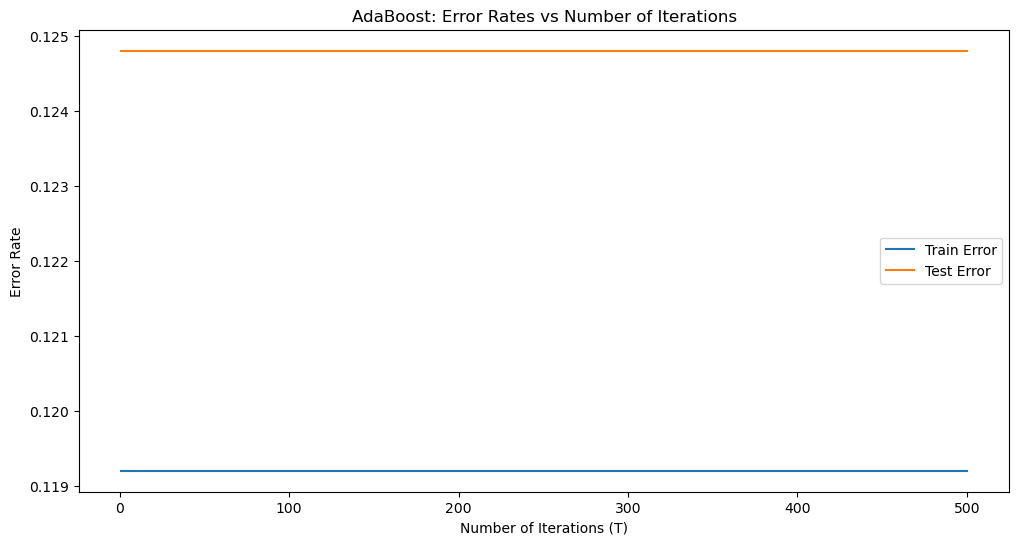

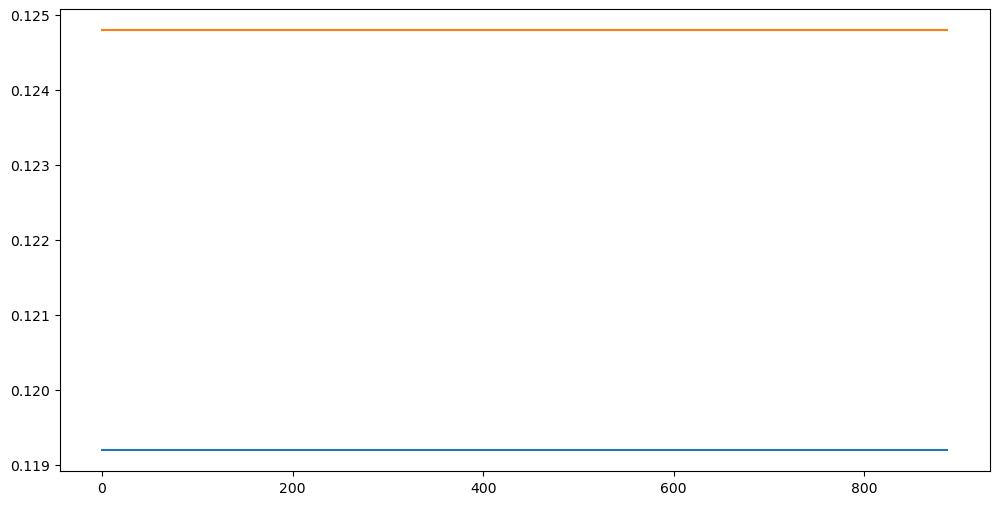

In [22]:
tree_range = [1, 2, 5, 10, 20, 50, 100, 200, 500]
features = list(train_data.columns[:-1])

n_iterations = len(tree_range)
train_errors = np.zeros(n_iterations)
test_errors = np.zeros(n_iterations)
train_stump_errors = []
test_stump_errors = []

for i, T in enumerate(tree_range):
    print(f"Iteration {T}")
    stumps, alphas, train_stump_err, test_stump_err = adaboost(T, train_data, test_data, features)

    _, train_errors[i] = adaboost_predict(train_data, stumps, alphas)
    _, test_errors[i] = adaboost_predict(test_data, stumps, alphas)

    train_stump_errors.extend(train_stump_err)
    test_stump_errors.extend(test_stump_err)

plt.figure(figsize=(12, 6))
plt.plot(tree_range, train_errors, label='Train Error')
plt.plot(tree_range, test_errors, label='Test Error')
plt.xlabel('Number of Iterations (T)')
plt.ylabel('Error Rate')
plt.legend()
plt.title('AdaBoost: Error Rates vs Number of Iterations')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(len(train_stump_errors)), train_stump_errors, label='Train Stump Errors')
plt.plot(range(len(test_stump_errors)), test_stump_errors, label='Test Stump Errors')
plt.xlabel('Iteration')
plt.ylabel('Error Rate')
plt.legend()
plt.title('AdaBoost: Error Rates vs Iteration')
plt.show()

## Problem 2A

In [44]:
# Define entropy
def entropy(target_col):
    _, counts = np.unique(target_col, return_counts=True)
    probabilities = counts / len(target_col)
    return -np.sum(probabilities * np.log2(probabilities))

In [45]:
# Define majority error with NumPy
def majority_error(target_col):
    return 1 - np.max(np.bincount(target_col) / len(target_col))

In [46]:
# Define gini index with NumPy
def gini_index(target_col):
    _, counts = np.unique(target_col, return_counts=True)
    probabilities = counts / len(target_col)
    return 1 - np.sum(probabilities**2)

In [47]:
# Information Gain with caching
def info_gain(data, split_attribute_name, target_name, criterion="entropy"):
    criterion_func = {'entropy': entropy, 'majority_error': majority_error, 'gini_index': gini_index}[criterion]
    total_impurity = criterion_func(data[target_name])

    weighted_impurity = 0
    for value, group in data.groupby(split_attribute_name):
        weighted_impurity += (len(group) / len(data)) * criterion_func(group[target_name])

    return total_impurity - weighted_impurity

In [48]:
def ID3_numeric(data, original_data, features, target_attribute_name="y", parent_node_class=None,
                max_depth=None, depth=0, criterion="entropy"):
    unique_targets = np.unique(data[target_attribute_name])
    if len(unique_targets) == 1:
        return unique_targets[0]

    if len(data) == 0:
        return get_majority_class(original_data, target_attribute_name)

    if len(features) == 0 or (max_depth and depth == max_depth):
        return parent_node_class

    parent_node_class = get_majority_class(data, target_attribute_name)

    gains = [info_gain(data, feature, target_attribute_name, criterion) for feature in features]
    best_feature = features[np.argmax(gains)]
    tree = {best_feature: {}}

    for value in np.unique(data[best_feature]):
        best_val = data[best_feature] == value
        sub_data = data.where(best_val).dropna()
        remaining_features = [feat for feat in features if feat != best_feature]
        subtree = ID3_numeric(
            data=sub_data,
            original_data=original_data,
            features=remaining_features,
            target_attribute_name=target_attribute_name,
            parent_node_class=parent_node_class,
            max_depth=max_depth,
            depth=depth + 1,
            criterion=criterion
        )
        tree[best_feature][value] = subtree
    return tree

In [49]:
def bag_predict(row, tree, default_class=None):
    current_node = tree
    while isinstance(current_node, dict):
        feature = next(iter(current_node))
        value = row[feature]
        next_node = current_node[feature].get(value, default_class)

        if next_node is default_class:
            return default_class

        current_node = next_node

    return current_node

In [50]:
def batch_vote(trees, data, default_class):
    all_predictions = []
    for tree in trees:
        try:
            if isinstance(data, pd.DataFrame):
                predictions = data.apply(lambda row: bag_predict(row, tree, default_class), axis=1)
            elif isinstance(data, pd.Series):
                predictions = bag_predict(data, tree, default_class)
            else:
                raise ValueError("Unsupported data type. Expected a DataFrame or Series.")
        except Exception as e:
            print(f"Error: {e}")
            print(f"Tree: {tree}")
            print(f"Default Class: {default_class}")
            raise  # Re-raise the caught exception

        all_predictions.append(predictions)

    all_predictions = np.array(all_predictions)

    if all_predictions.ndim > 1:
        final_predictions = mode(all_predictions, axis=0)[0][0]
    else:
        final_predictions = all_predictions[0]

    return final_predictions

In [51]:
def get_majority_class(data, target_attribute_name):
    return data[target_attribute_name].mode()[0]

In [52]:
def create_bootstrap_sample(data):
    return data.sample(replace=True)

In [53]:
def bagging(n_trees, train_data, test_data, features, target="y", default_class=None):
    trees = [ID3_numeric(train_data.sample(frac=1, replace=True), train_data, features) for _ in range(n_trees)]

    train_predictions = batch_vote(trees, train_data, default_class)
    test_predictions = batch_vote(trees, test_data, default_class)

    train_error = np.mean(train_predictions != train_data[target].to_numpy())
    test_error = np.mean(test_predictions != test_data[target].to_numpy())

    return trees, train_error, test_error

## Problem 2B

Number of trees: 1
Number of trees: 10
Number of trees: 50
Number of trees: 100
Number of trees: 200
Number of trees: 500


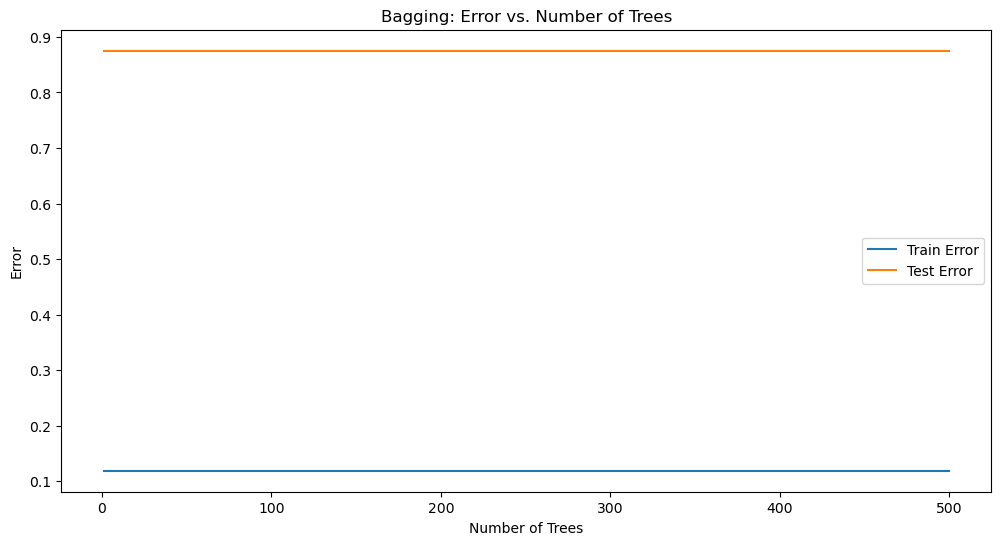

In [33]:
# Number of trees to try
n_trees_values = [1, 10, 50, 100, 200, 500]
train_errors = []
test_errors = []

default_class = get_majority_class(train_data, target_attribute_name="y")
features = list(train_data.columns[:-1])

# Main loop for Bagging experiment
for n_trees in n_trees_values:
    print(f"Number of trees: {n_trees}")
    _, train_error, test_error = bagging(n_trees, train_data, test_data, features, default_class=default_class)
    train_errors.append(train_error)
    test_errors.append(test_error)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(n_trees_values, train_errors, label='Train Error')
plt.plot(n_trees_values, test_errors, label='Test Error')
plt.xlabel('Number of Trees')
plt.ylabel('Error')
plt.legend()
plt.title('Bagging: Error vs. Number of Trees')
plt.show()

## Problem 2C

In [54]:
n_runs = 100
n_trees = 500
sample_size = 1000
test_size = len(test_data)

single_tree_predictions = np.zeros((n_runs, test_size), dtype=int)
bagged_tree_predictions = np.zeros((n_runs, test_size, n_trees), dtype=int)

for run in range(n_runs):
    print(f"Run {run + 1}...")

    sampled_data = train_data.sample(sample_size, replace=False)

    trees = [ID3_numeric(create_bootstrap_sample(sampled_data), sampled_data, features) for _ in range(n_trees)]

    single_tree = trees[0]
    single_tree_predictions[run] = np.array([bag_predict(row, single_tree) for _, row in test_data.iterrows()])

    bagged_tree_predictions[run] = np.array([[bag_predict(row, tree) for tree in trees] for _, row in test_data.iterrows()])

true_labels = test_data['y'].to_numpy()

bias_single = np.mean((true_labels - np.mean(single_tree_predictions, axis=0)) ** 2)
variance_single = np.mean(np.var(single_tree_predictions, axis=0))
general_error_single = bias_single + variance_single

mean_bagged_predictions = np.mean(bagged_tree_predictions, axis=(0, 2))
bias_bagged = np.mean((true_labels - mean_bagged_predictions) ** 2)
variance_bagged = np.mean(np.var(np.mean(bagged_tree_predictions, axis=2), axis=0))
general_error_bagged = bias_bagged + variance_bagged

print(f"Bias for single trees: {bias_single}")
print(f"Variance for single trees: {variance_single}")
print(f"General squared error for single trees: {general_error_single}")

print(f"Bias for bagged trees: {bias_bagged}")
print(f"Variance for bagged trees: {variance_bagged}")
print(f"General squared error for bagged trees: {general_error_bagged}")

Run 1...
Run 2...
Run 3...
Run 4...
Run 5...
Run 6...
Run 7...
Run 8...
Run 9...
Run 10...
Run 11...
Run 12...
Run 13...
Run 14...
Run 15...
Run 16...
Run 17...
Run 18...
Run 19...
Run 20...
Run 21...
Run 22...
Run 23...
Run 24...
Run 25...
Run 26...
Run 27...
Run 28...
Run 29...
Run 30...
Run 31...
Run 32...
Run 33...
Run 34...
Run 35...
Run 36...
Run 37...
Run 38...
Run 39...
Run 40...
Run 41...
Run 42...
Run 43...
Run 44...
Run 45...
Run 46...
Run 47...
Run 48...
Run 49...
Run 50...
Run 51...
Run 52...
Run 53...
Run 54...
Run 55...
Run 56...
Run 57...
Run 58...
Run 59...
Run 60...
Run 61...
Run 62...
Run 63...
Run 64...
Run 65...
Run 66...
Run 67...
Run 68...
Run 69...
Run 70...
Run 71...
Run 72...
Run 73...
Run 74...
Run 75...
Run 76...
Run 77...
Run 78...
Run 79...
Run 80...
Run 81...
Run 82...
Run 83...
Run 84...
Run 85...
Run 86...
Run 87...
Run 88...
Run 89...
Run 90...
Run 91...
Run 92...
Run 93...
Run 94...
Run 95...
Run 96...
Run 97...
Run 98...
Run 99...
Run 100...
Bias for

## Problem 2D

In [55]:
import random
def ID3_numeric_random_features(data, original_data, features, target_attribute_name="y", parent_node_class=None,max_depth=None, depth=0, criterion="entropy", feature_subset_size=None):
    unique_targets = np.unique(data[target_attribute_name])
    if len(unique_targets) == 1:
        return unique_targets[0]

    if len(data) == 0:
        return get_majority_class(original_data, target_attribute_name)

    if len(features) == 0 or (max_depth and depth == max_depth):
        return parent_node_class

    parent_node_class = get_majority_class(data, target_attribute_name)

    if feature_subset_size:
        selected_features = random.sample(features, feature_subset_size)
    else:
        selected_features = features

    gains = [info_gain(data, feature, target_attribute_name, criterion) for feature in selected_features]
    best_feature = selected_features[np.argmax(gains)]
    tree = {best_feature: {}}

    for value in np.unique(data[best_feature]):
        best_val = data[best_feature] == value
        sub_data = data.where(best_val).dropna()
        remaining_features = [feat for feat in features if feat != best_feature]
        subtree = ID3_numeric_random_features(
            data=sub_data,
            original_data=original_data,
            features=remaining_features,
            target_attribute_name=target_attribute_name,
            parent_node_class=parent_node_class,
            max_depth=max_depth,
            depth=depth + 1,
            criterion=criterion,
            feature_subset_size=feature_subset_size  # Pass along the feature subset size
        )

        tree[best_feature][value] = subtree

    return tree

In [56]:
def random_forest(n_trees, train_data, test_data, features, target="y", n_features=None, default_class=None):
    trees = []
    for _ in range(n_trees):

        bootstrap_data = create_bootstrap_sample(train_data)
        tree = ID3_numeric_random_features(bootstrap_data, bootstrap_data, features, feature_subset_size=n_features)
        trees.append(tree)

    train_predictions = np.array([batch_vote(trees, row,default_class) for _, row in train_data.iterrows()])
    test_predictions = np.array([batch_vote(trees, row, default_class) for _, row in test_data.iterrows()])

    train_error = sum(train_predictions != train_data[target].to_numpy()) / len(train_data)
    test_error = sum(test_predictions != test_data[target].to_numpy()) / len(test_data)

    return trees, train_error, test_error

In [57]:
feature_subset_sizes = [2, 4, 6]
n_trees_values = list(range(1, 501))
default_class = get_majority_class(train_data, target_attribute_name="y")
for n_features in feature_subset_sizes:
    impurity_cache.clear()
    train_errors_rf = []
    test_errors_rf = []
    for n_trees in n_trees_values:
        print(f"Number of trees: {n_trees}, Number of features: {n_features}")
        _, train_error_rf, test_error_rf = random_forest(n_trees, train_data, test_data, features, n_features=n_features, default_class=default_class)
        train_errors_rf.append(train_error_rf)
        test_errors_rf.append(test_error_rf)

    plt.figure(figsize=(12, 6))
    plt.plot(n_trees_values, train_errors_rf, label=f'Train Error with {n_features} features')
    plt.plot(n_trees_values, test_errors_rf, label=f'Test Error with {n_features} features')
    plt.xlabel('Number of Trees')
    plt.ylabel('Error')
    plt.legend()
    plt.title(f'Random Forest: Error vs. Number of Trees with {n_features} features')
    plt.show()

Number of trees: 1, Number of features: 2
Number of trees: 2, Number of features: 2
Number of trees: 3, Number of features: 2
Number of trees: 4, Number of features: 2
Number of trees: 5, Number of features: 2
Number of trees: 6, Number of features: 2
Number of trees: 7, Number of features: 2
Number of trees: 8, Number of features: 2
Number of trees: 9, Number of features: 2
Number of trees: 10, Number of features: 2
Number of trees: 11, Number of features: 2
Number of trees: 12, Number of features: 2
Number of trees: 13, Number of features: 2
Number of trees: 14, Number of features: 2
Number of trees: 15, Number of features: 2
Number of trees: 16, Number of features: 2
Number of trees: 17, Number of features: 2
Number of trees: 18, Number of features: 2
Number of trees: 19, Number of features: 2
Number of trees: 20, Number of features: 2
Number of trees: 21, Number of features: 2
Number of trees: 22, Number of features: 2
Number of trees: 23, Number of features: 2
Number of trees: 24,

KeyboardInterrupt: 

## Problem 2E

In [58]:
single_random_tree_predictions = []
random_forest_predictions = []

n_runs = 100  
sample_size = 1000 
n_features = 4  
n_trees_rf = 500  
impurity_cache.clear()  

for run in range(n_runs):
    print(f"Run {run + 1}...")
    sampled_data = train_data.sample(sample_size, replace=False)

    trees_rf, _, _ = random_forest(n_trees_rf, sampled_data, test_data, features, n_features=n_features)

    single_random_tree = trees_rf[0]
    single_random_tree_predictions.append([bag_predict(row, single_random_tree) for _, row in test_data.iterrows()])

    random_forest_preds = [[bag_predict(row, tree) for tree in trees_rf] for _, row in test_data.iterrows()]
    random_forest_predictions.append(random_forest_preds)

single_random_tree_predictions = np.array(single_random_tree_predictions)
random_forest_predictions = np.array(random_forest_predictions)

bias_single_random = np.mean((true_labels - np.mean(single_random_tree_predictions, axis=0)) ** 2)
variance_single_random = np.mean(np.var(single_random_tree_predictions, axis=0))
general_error_single_random = bias_single_random + variance_single_random

mean_rf_predictions = np.mean(random_forest_predictions, axis=2)

bias_rf = np.mean((true_labels - np.mean(mean_rf_predictions, axis=0)) ** 2)
variance_rf = np.mean(np.var(mean_rf_predictions, axis=0))
general_error_rf = bias_rf + variance_rf

print(f"Bias for single random trees: {bias_single_random}")
print(f"Variance for single random trees: {variance_single_random}")
print(f"General squared error for single random trees: {general_error_single_random}")

print(f"Bias for random forests: {bias_rf}")
print(f"Variance for random forests: {variance_rf}")
print(f"General squared error for random forests: {general_error_rf}")

Run 1...
Run 2...
Run 3...
Run 4...
Run 5...
Run 6...
Run 7...
Run 8...
Run 9...
Run 10...
Run 11...
Run 12...
Run 13...
Run 14...
Run 15...
Run 16...
Run 17...
Run 18...
Run 19...
Run 20...
Run 21...
Run 22...
Run 23...
Run 24...
Run 25...
Run 26...
Run 27...
Run 28...
Run 29...
Run 30...
Run 31...
Run 32...
Run 33...
Run 34...
Run 35...
Run 36...
Run 37...
Run 38...
Run 39...
Run 40...
Run 41...
Run 42...
Run 43...
Run 44...
Run 45...
Run 46...
Run 47...
Run 48...
Run 49...
Run 50...
Run 51...
Run 52...
Run 53...
Run 54...
Run 55...
Run 56...
Run 57...
Run 58...
Run 59...
Run 60...
Run 61...
Run 62...
Run 63...
Run 64...
Run 65...
Run 66...
Run 67...
Run 68...
Run 69...
Run 70...
Run 71...
Run 72...
Run 73...
Run 74...
Run 75...
Run 76...
Run 77...
Run 78...
Run 79...
Run 80...
Run 81...
Run 82...
Run 83...
Run 84...
Run 85...
Run 86...
Run 87...
Run 88...
Run 89...
Run 90...
Run 91...
Run 92...
Run 93...
Run 94...
Run 95...
Run 96...
Run 97...
Run 98...
Run 99...
Run 100...
Bias for